In [1]:
#a bunch of import statements for the functions we'll be using
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest
import numpy as np
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Clustering Documents #
### Reading in the DTM ###
First we'll read in the DTM (Document Term Matrix) from a CSV (comma-separated values) file. We're using a DTM that has been cleaned of all stopwords and normalized.

The first line of the csv consists of a list of all the words, so we'll load that in first.

In [133]:
with open('Erik/onegramfilteredtfidf.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    words = iter(reader).next()
words = words[1:]

In [134]:
words[:10] #print out the first 10 words as a sanity check

['1-kam-ma[1st]NU',
 '1/2[1/2]NU',
 '1/3[1/3]NU',
 '10-kam-ma[10th]NU',
 '1000[1000]NU',
 '100[100]NU',
 '108000[108000]NU',
 '1080[1080]NU',
 '108[108]NU',
 '10[10]NU']

Now we read in the rest of the DTM using the loadtxt function provided by NumPy.

In [146]:
dtm = np.loadtxt('Erik/onegramfilteredtfidf.csv', delimiter=',', skiprows=1, converters = {0: lambda s: 0})
dtm = np.delete(dtm, 0, 1)

We now try to cluster documents that are similar to each other.

### K-Means Clustering ###

[K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering) is an iterative method to group vectors into k clusters. To do this, it first randomizes k cluster centers. The algorithm then assigns vectors to their closest cluster center, then redefines the cluster center according to the current set of clusters. This process repeats until convergence.

Let's try executing K-Means using 7 clusters. I picked 5 arbitrarily - in the future we can try using the "[elbow method](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method)" to determine a number of clusters, or we can try different options and manually inspect the clusters to see if they make any sense.

In [152]:
dtm_normalized_kmeans = KMeans(n_clusters=7, max_iter=1000).fit(dtm)

We can examine the "label" of each of the documents as defined by this clustering - this tells us which cluster each of the documents is classified under.

In [153]:
labels = dtm_normalized_kmeans.labels_
labels

array([2, 3, 3, 3, 3, 3, 6, 1, 3, 3, 6, 2, 2, 3, 3, 1, 2, 4, 3, 2, 4, 1, 1,
       4, 1, 4, 1, 2, 0, 0, 0, 2, 4, 2, 2, 4, 4, 5, 4, 2, 2, 2, 2, 2, 2, 3,
       4, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 6,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 4, 3, 3, 2, 1, 1, 1,
       0, 0, 0, 6, 6, 6, 6, 6, 3, 6, 6, 0, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0,
       1, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 6, 6, 0, 6, 0, 6, 0, 0, 0,
       0, 0, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 2, 6, 6, 6, 6, 2, 3, 6, 6, 6, 6,
       1, 6, 6, 0, 6, 6, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5,
       5, 5, 5, 2, 5, 5, 5, 2, 2, 4, 2, 4, 5, 2, 2, 2, 2, 6, 6, 2, 6, 2, 6,
       6, 2, 3, 6, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 4, 1, 3, 6, 6, 1, 6, 4, 6, 2, 6, 6,
       6, 6, 1, 6, 6, 3, 6, 6, 6, 2, 1, 2, 3, 3, 6, 1, 6, 6, 2, 6, 6, 6, 4,
       6, 6, 6, 2, 6, 1, 6, 6, 0, 0, 0, 0, 0, 0, 3, 6, 6, 0, 2, 1, 2, 6, 3,
       6, 6,

It seems like a there is a nice spread of documents being assigned to different clusters. (what we don't want is something like 50% or more of the documents falling into the same cluster).

Let's see what the centers of each of the clusters look like.

In [154]:
cluster_centers = dtm_normalized_kmeans.cluster_centers_
cluster_centers

array([[  2.23583679e-03,   2.60208521e-18,   3.25260652e-19, ...,
          0.00000000e+00,   1.29213577e-03,   0.00000000e+00],
       [  9.41549850e-04,   4.58510242e-04,   3.25260652e-19, ...,
         -3.25260652e-19,   5.42101086e-20,   1.62630326e-19],
       [  5.73040317e-03,   1.01907021e-02,   2.19342776e-03, ...,
         -3.25260652e-19,   4.60293221e-04,   6.27082624e-04],
       ..., 
       [  1.45587158e-03,   1.41302322e-02,   1.99804602e-03, ...,
          2.96749886e-03,   7.57473981e-04,   3.70837169e-04],
       [  2.44743356e-03,   1.73472348e-18,   2.16840434e-19, ...,
          2.16840434e-19,  -1.08420217e-19,  -2.71050543e-20],
       [  9.65788534e-04,   9.36958620e-05,   0.00000000e+00, ...,
          1.93219556e-03,   3.25260652e-19,  -1.08420217e-19]])

Interesting... We get a nice variation across cluster centers (i.e. not all 0s or anything like that), so we can move on.

(probably omit this next part)

Below I now define a method that takes in a cluster number, and outputs a dictionary whose values are lists of documents that belong to a specific cluster. The idea is that someone familiar with this corpus could look at the output and determine if the clustering makes any sense whatsoever.

In [ ]:
def inspect_clusters(num_clusters):
    km = KMeans(n_clusters=num_clusters, max_iter=1000).fit(dtm_normalized)
    labels = km.labels_
    clusters = {}
    for i in range(num_clusters):
        docs = [j for j in range(len(labels)) if labels[j] == i]
        clusters[i] = docs
    return clusters

### K-Means Visualization ###
It's difficult to visualize the clustering of 4000+ dimension vectors (each term  adds to the dimensionality of the vecotrs).

Here we attempt to use feature selection - trying to pick out two or three of the most "significant" features (where features are terms in this case) and plot those features onto 2D or 3D graphs. Below we try two different selection criteria to determine which terms to plot.

This one sees which word has the highest tf-idf values across the clusters we choose to plot.

In [20]:
# gives the features with the largest magnitude (summed across given cluster centers)
def largest_selector(clusters, num_features):
    size = []
    for feat in range(len(clusters[0])):
        size.append((feat, sum([c[feat] for c in clusters])))
    size = sorted(size, key=lambda t: -t[1]) 
    return size[:num_features]

This one sees which word has the highest difference across tf-idf values across the clusters we choose to plot.

In [21]:
# gives the features with the largest difference between clusters
def largest_diff_selector(clusters, num_features):
    tot_diff = []
    for feat in range(len(clusters[0])):
        tot_diff.append((feat, sum([abs(c1[feat] - c2[feat]) for c1 in clusters for c2 in clusters])))
    tot_diff = sorted(tot_diff, key=lambda t: -t[1])
    return tot_diff[:num_features]

Below I've defined two functions that take in a list of cluster numbers, a selector function (one of the two just defined above, and a new text - a text that is not yet in the corpus that we want to compare.

Each of these functions will use matplotlib to plot a scatterplot of the clusters selected (in different colors) according to the frequency of the terms that were selected by the selector function. They will also print out the terms that were selected.

Don't worry too much about how these functions work. We'll go through a couple examples below.

In [173]:
def plot2d(clusters, selector_func, new_text=None):
    selected_features = selector_func([cluster_centers[i] for i in clusters], 2)
    selected_features = [f[0] for f in selected_features]
    
    selected_dtm = dtm[:,selected_features]
    mask = lambda i: [lbl == i for lbl in labels]
    cluster_vectors = [selected_dtm[mask(i)] for i in clusters]
    colors = iter(['bs', 'ys', 'gs', 'cs'])
    for cluster in cluster_vectors:
        X, Y = zip(*cluster)
        plt.plot(X, Y, colors.next())
    if(new_text is not None):
        plt.plot(new_text[selected_features[0]], new_text[selected_features[1]], 'r^')
    plt.show()
    print('X: ' + words[selected_features[0]])
    print('Y: ' + words[selected_features[1]])
    return selected_features
    
def plot3d(clusters, selector_func, new_text=None):
    selected_features = selector_func([cluster_centers[i] for i in clusters], 3)
    selected_features = [f[0] for f in selected_features]
    
    selected_dtm = dtm[:,selected_features]
    mask = lambda i: [lbl == i for lbl in labels]
    cluster_vectors = [selected_dtm[mask(i)] for i in clusters]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for cluster in cluster_vectors:
        X, Y, Z = zip(*cluster)
        ax.scatter(X, Y, Z)
    if(new_text is not None):
        X, Y, Z = new_text[selected_features[0]], new_text[selected_features[1]], new_text[selected_features[2]]
        ax.scatter(X, Y, Z)
    plt.draw()
    plt.show()
    print('X: ' + words[selected_features[0]])
    print('Y: ' + words[selected_features[1]])
    print('Z: ' + words[selected_features[2]])
    return selected_features

Let's try using these functions now. First, 2D.

Below I pass in [0, 1] as clusters (meaning we want to visualize the documents in the 0th and 1st cluster). We are using the largest_selector function to pick out two features.

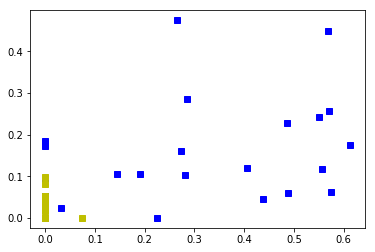

X: Ninurtak[1]DN
Y: ursa?[hero]N


In [175]:
selected = plot2d([0, 1], largest_selector)

We can see that cluster0 (in blue) has greater variation across the x-axis, or the term  'Ninurtak[1]DN', whereas cluster1 (in yellow) has more variation across the y-axis, the term 'ursa?[hero]N'. 

Let's try passing in the exact same thing, but also add in a "new text". Let's treat the second document of the DTM as our new text for now.

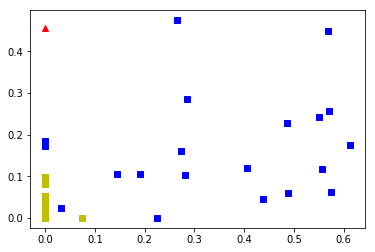

X: Ninurtak[1]DN
Y: ursa?[hero]N


In [206]:
selected = plot2d([0, 1], largest_selector, new_text=dtm[1])

Our "new text", marked in red, seems pretty far from the others documents in the two clusters, so we might predict that it doesn't fall into either of the clusters we've chosen to visualize.

Let's try passing in the exact same paramenters into the 3D function.

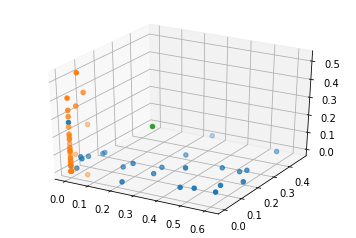

X: Ninurtak[1]DN
Y: ursa?[hero]N
Z: Inanak[1]DN


In [207]:
selected = plot3d([0, 1], largest_selector, new_text=dtm[1])

We see the same results as before, except we now see that cluster1 (in orange) has variation across the third term our selector chose, 'Inanak[1]DN', whereas cluster0 and our new_text (in green) seem to not vary across this third term much.

We can also throw in more clusters (than two) into the function. Here I call the same function, but also include cluster3.

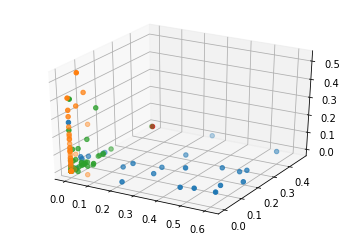

X: Ninurtak[1]DN
Y: ursa?[hero]N
Z: Inanak[1]DN


In [184]:
selected = plot3d([0, 1, 3], largest_selector, new_text=dtm[1])

Here we see that cluster3 (green), like cluster1 (orange), doesn't vary much in the x-axis, though it does have more variation in the y-axis than cluster1. Our new text still doesn't look like it fits any of these too well.

If you look at labels up above, we could see that it's actually classified into cluster3. One might have been able to guess this? - it has a larger y-value (like cluster0 and cluster3), but a 0 x-value (unlike cluster0).


Below I write out a couple other usages of these functions. See if you can explain in words what they are visualizing, and what the differences between the clusters seem to be.

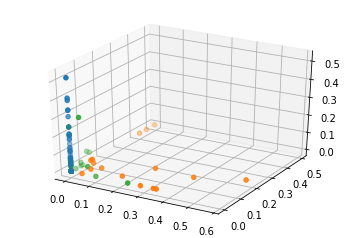

X: mada[land]N
Y: erin[people]N
Z: Inanak[1]DN


In [228]:
selected = plot3d([1, 5, 6], largest_diff_selector)

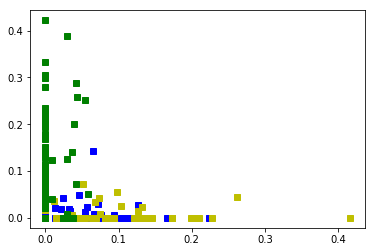

X: gu[eat]V/t
Y: me[Being]N


In [239]:
selected = plot2d([2, 4, 6], largest_diff_selector)

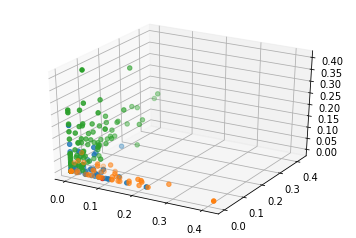

X: gu[eat]V/t
Y: me[Being]N
Z: mah[great]V/i


In [240]:
selected = plot3d([2, 4, 6], largest_diff_selector)

### Hierarchical Clustering ###
We'll use "agglomerative clustering" here.

In agglomerative clustering, each document starts as a cluster.
The algorithm will look for which clusters are most similar and will pair them up ("link" them) to form a new cluster. Now we have one fewer clusters (because two clusters just became one). This keeps happening until *all* the documents are part of a single cluster.



In [209]:
dtm_normalized_hierarchical = AgglomerativeClustering(7).fit(dtm_normalized)

We can check the number of "leaves" as a sanity check. This should equal the number of documents.

In [210]:
dtm_normalized_hierarchical.n_leaves_

356L

We can also check the labels of each document. Like with k-means, this represents which cluster this method would place each document in.

In [211]:
hierarchical_labels = dtm_normalized_hierarchical.labels_
hierarchical_labels

array([1, 4, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4,
       1, 1, 1, 1, 1, 5, 5, 4, 1, 1, 4, 1, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 0, 0, 1, 1, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 1, 0, 0, 0, 0,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 5, 4, 4, 4, 4, 1, 1, 0, 0, 1, 1, 1,
       5, 0, 0, 0, 4, 0, 0, 0, 6, 1, 2, 4, 4, 1, 1, 2, 4, 2, 2, 2, 2, 2, 4,
       1, 4, 2, 5, 2, 4, 2, 2, 4, 4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
       4, 5, 4, 4, 0, 0, 4, 4, 4, 0, 4, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6,
       6, 6, 6, 3, 1, 1, 6, 4, 1, 3, 3, 1, 1, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 4, 4, 4, 1, 0, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 1, 2, 1, 1, 1, 5, 5, 5, 5, 1, 4, 4, 2, 2, 4, 1, 1, 1, 2, 1,
       4, 1,

Like with k-means, we see that there is a fair amount of variation in the labels.

We can also look at the "children" attribute. This tells us how the documents were linked together.

In [212]:
children = dtm_normalized_hierarchical.children_
children[:10]

array([[115, 242],
       [ 65,  66],
       [ 41,  42],
       [  2,   3],
       [133, 137],
       [ 93,  94],
       [  5, 359],
       [128, 129],
       [ 28,  29],
       [ 59,  60]], dtype=int64)

The first pair of the array indicates which two documents were linked together first. For example, if the array looked like what's below:

In [219]:
np.array([[115, 242],[ 65,  66],[ 41,  42],[  2,   3],[133, 137]])

array([[115, 242],
       [ 65,  66],
       [ 41,  42],
       [  2,   3],
       [133, 137]])

This would mean that documents 115 and 242 were linked together first, followed by documents 65 and 66, etc.

Note that this means the children array should have length one less than the total number of documents. Think about why this is.

### Hierarchical Visualization ###
Let's draw a dendrogram! Here we're going to use scipy's function.

First we go through the agglomerative proceess (called "linkage").

In [213]:
Z = linkage(dtm_normalized)

And now we plot all the documents in a dendrogram. A dengrogram looks like a tree in that it starts with a root, and splits off into more and more "branches", which then keep splitting until we reach "leaves", which in this case are documents. Leaves on the same branch as "similar" to each other as decided by the linkage function.

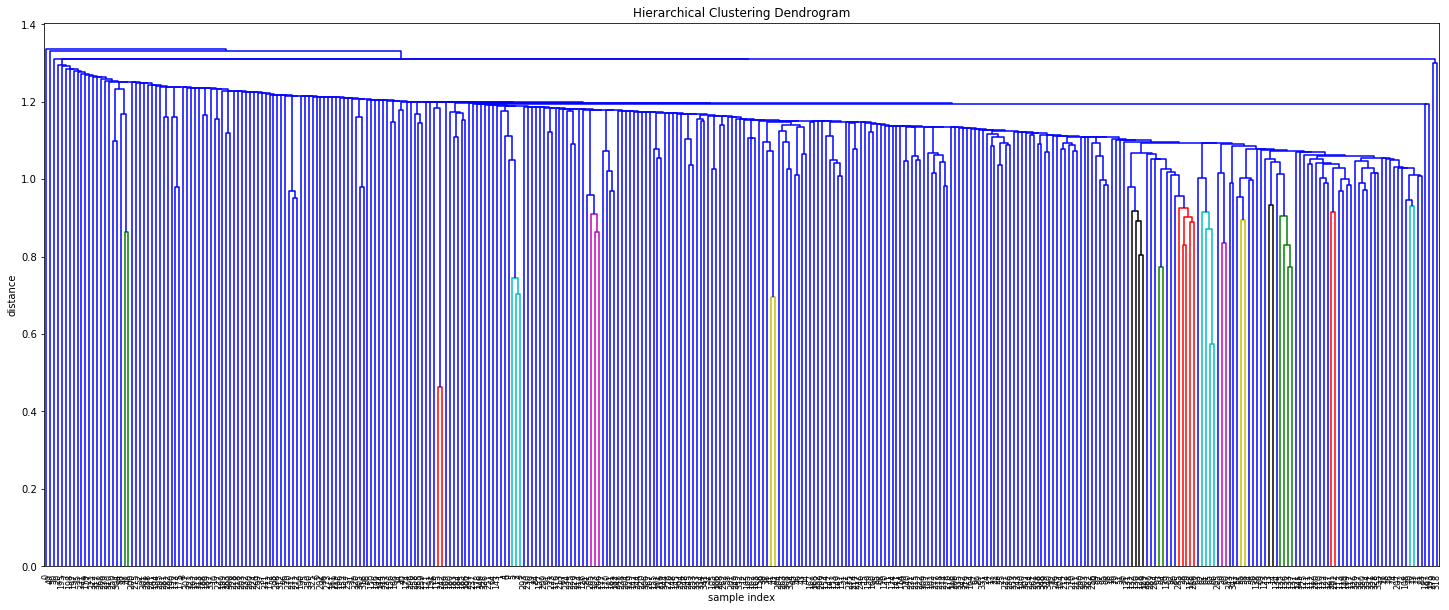

In [214]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

This is way too crowded, since it has all 394 documents. Let's try it on some subset of the documents - maybe the ones from a specific cluster.

So first we select only the documents from cluster 0.

In [215]:
# select only documents from one of the clusters
selected_hierarchical = dtm[[i for i in range(len(hierarchical_labels)) if hierarchical_labels[i] == 0]]

Then we go through the agglomerative process.

In [216]:
Z2 = linkage(selected_hierarchical)

And now we plot!

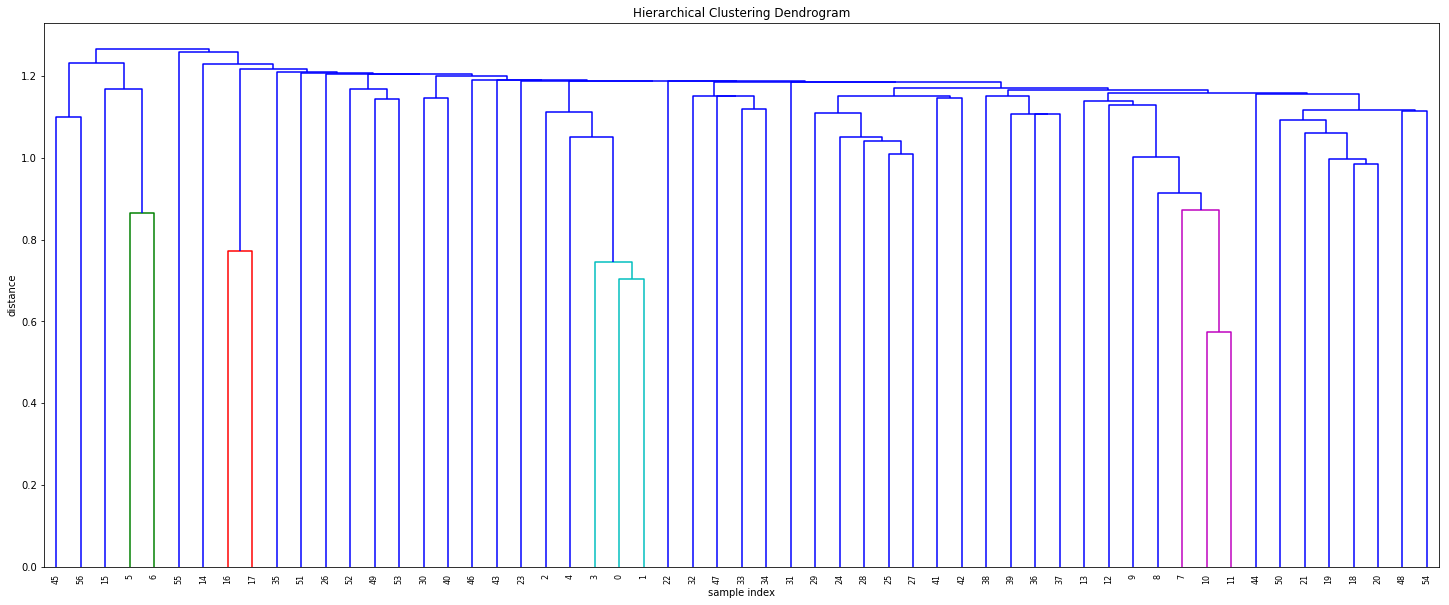

In [217]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z2,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

We can now clearly see (if we go from bottom up) the progression in which the documents were linked together. For example, documents 10 and 11 (near the right) were linked togehter pretty early (meaning they were deemed relatively "similar"), this new "cluster" was then linked with document 7, then 8, then 9.